# Testing behavioural performance of DAGs

## Setup

In [1]:
FORCE_CPU = False
SEED = 2384
MODEL_NAME = "gelu-1l"

OPEN_PAREN_STR_TOKENS = ["("]
CLOSE_PAREN_STR_TOKENS = [")"]
SUPPRESSING_STR_TOKENS = ["(", "_", ",", "+", "."]

DATA_FILES = {
    "single_line": "../../data/paren-balancing/single_line.csv",
    "synthetic len:31": "../../data/paren-balancing/synthetic_a_l31.csv",
    "synthetic len:15": "../../data/paren-balancing/synthetic_a_l15.csv",
    "synthetic len:31 depth:3": "../../data/paren-balancing/synthetic_a_l31_d3.csv",
}

SAVE_MODEL_PREDICTIONS = True
LOAD_MODEL_PREDICTIONS = False
MODEL_PREDICTIONS_DATA_FILE = "../saved_data/model_predictions.pt"

DATASET_MAX_SIZE = 10000

DAG_BATCH_SIZE = 10000
MODEL_BATCH_SIZE = 64

PROB_THRESHOLD_SIGMA = 1

In [2]:
from IPython.display import display

import random

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from rich.table import Table
from rich.console import Console

from tqdm import tqdm

from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy

from causal_networks.dag import (
    DAGModel,
    InputNode,
    GreaterThanZeroNode,
    InSetOutSetNode,
    CumSumNode,
)
from causal_networks.predefined_models import make_basic_pb_dag, make_suppressing_pb_dag
from causal_networks.variable_alignment import TransformerVariableAlignment

In [3]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
import plotly.io as pio
pio.renderers.default = "colab+vscode"

## Load model, DAGs and datasets

In [5]:
model = HookedTransformer.from_pretrained(MODEL_NAME, device=device)

Loaded pretrained model gelu-1l into HookedTransformer


In [6]:
open_paren_tokens = model.to_tokens(
    OPEN_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
open_paren_tokens = [
    open_paren_tokens[i, 0].item() for i in range(open_paren_tokens.shape[0])
]

closed_paren_tokens = model.to_tokens(
    CLOSE_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
closed_paren_tokens = [
    closed_paren_tokens[i, 0].item() for i in range(closed_paren_tokens.shape[0])
]

suppressing_tokens = model.to_tokens(
    SUPPRESSING_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
suppressing_tokens = [
    suppressing_tokens[i, 0].item() for i in range(suppressing_tokens.shape[0])
]

print("Open paren tokens:", open_paren_tokens)
print("Closed paren tokens:", closed_paren_tokens)
print("Suppressing tokens:", suppressing_tokens)

Open paren tokens: [10]
Closed paren tokens: [11]
Suppressing tokens: [10, 65, 14, 13, 16]


In [7]:
def output_modifier(y: torch.tensor):
    binary_output = torch.empty(*y.shape[:-1], 2, device=y.device)
    binary_output[..., 0] = y[..., open_paren_tokens].sum(dim=-1)
    binary_output[..., 1] = y[..., closed_paren_tokens].sum(dim=-1)
    return binary_output

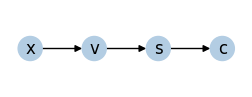

                  Node Information                   
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module                                     ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x    │ InputNode()                                │
│ v    │ InSetOutSetNode(in_set=[10], out_set=[11]) │
│ s    │ CumSumNode(dim=-1)                         │
│ c    │ GreaterThanZeroNode()                      │
└──────┴────────────────────────────────────────────┘

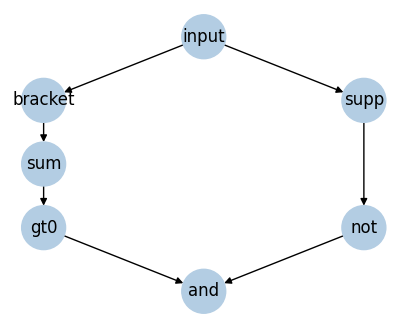

                    Node Information                    
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node    ┃ Module                                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input   │ InputNode()                                │
│ bracket │ InSetOutSetNode(in_set=[10], out_set=[11]) │
│ sum     │ CumSumNode(dim=-1)                         │
│ gt0     │ GreaterThanZeroNode()                      │
│ supp    │ InSetNode(in_set=[10, 65, 14, 13, 16])     │
│ not     │ NotNode()                                  │
│ and     │ AndNode()                                  │
└─────────┴────────────────────────────────────────────┘

In [8]:
dags = {
    "basic": make_basic_pb_dag(model, device=device),
    "suppressing": make_suppressing_pb_dag(model, device=device),
}
for name, dag in dags.items():
    dag.visualize(display_node_table=True)

In [9]:
datasets = {}
for name, dataset_filename in DATA_FILES.items():
    df = pd.read_csv(dataset_filename)
    df = df.sample(frac=1, random_state=SEED)
    df = df[:DATASET_MAX_SIZE]
    datasets[name] = df
    display(datasets[name].head().style.set_caption(name))

,text
289,grad_d = load(grad_d_file).2
18605,melt_value_vars = [c for c in df.columns if re.search(
112171,expr_list.append(expr_s)
15500,"self.config_fixture.config(group='cache', enabled=True).1"
37765,report_doc.updated_on = datetime.datetime.now(tz=bson.tz_util.utc)


,text
90144,(p(h(j(V)l)q(R)F(H)n(e(S(m(k)w(
2681,(u)q(A(p(w(b(T(H)l)K)k(r(b)y)C)
61912,(X)C(T(u(j)K(i(U)E(v)Y)T)r)o(g(
51794,(v(X)Q)x(K(S(V)z)F(P)r(f(b(y(h(
16530,(o(T(N)c)w)C(l)h(x)e(u(S(e(e)n(


,text
90144,(u)H(D)I(u(o)J)
2681,(c(h)E)g(P(l)K(
61912,(R(h)E)o(A)K(t)
51794,(m(t)G)j(k(I(O)
16530,(f(T(Q)H)R)r(Y)


,text
90144,(p(h(j)V(l)q(R)F(H)n(e)S)m)k(w)
2681,(u)q(A(p(w)b)T)H(l(K(k)r)b(y(C)
61912,(X)C(T(u(j)K(i)U(E)v(Y)T)r)o(g(
51794,(v(X)Q)x(K(S(V)z)F(P)r(f(b)y)h)
16530,(o(T(N)c)w)C(l)h(x)e(u(S(e)e(n)


In [10]:
tokenised_datasets = {}
for name, dataset in datasets.items():
    tokenised_datasets[name] = model.to_tokens(
        dataset["text"].values, move_to_device=False
    )

In [11]:
for name, dataset in tokenised_datasets.items():
    print(name, dataset.shape)

single_line torch.Size([10000, 118])
synthetic len:31 torch.Size([10000, 32])
synthetic len:15 torch.Size([10000, 16])
synthetic len:31 depth:3 torch.Size([10000, 32])


## Test performance

In [12]:
if LOAD_MODEL_PREDICTIONS:
    model_logits, model_probs = torch.load(MODEL_PREDICTIONS_DATA_FILE)
else:
    model_logits = {}
    model_probs = {}
    for name, dataset in tokenised_datasets.items():
        model_logits[name] = torch.empty(
            (*tokenised_datasets[name].shape, 2), dtype=torch.float
        )
        model_probs[name] = torch.empty(
            (*tokenised_datasets[name].shape, 2), dtype=torch.float
        )
        for batch_start in tqdm(
            range(0, len(dataset), MODEL_BATCH_SIZE), desc=f"Running model on {name}"
        ):
            batch_slice = slice(batch_start, batch_start + MODEL_BATCH_SIZE)
            batch = dataset[batch_slice].to(device)
            with torch.no_grad():
                model_output = model(batch).to("cpu")
            model_output_probs = F.softmax(model_output, dim=-1)
            model_logits[name][batch_slice, ..., 0] = model_output[
                ..., open_paren_tokens
            ].sum(dim=-1)
            model_logits[name][batch_slice, ..., 1] = model_output[
                ..., closed_paren_tokens
            ].sum(dim=-1)
            model_probs[name][batch_slice, ..., 0] = model_output_probs[
                ..., open_paren_tokens
            ].sum(dim=-1)
            model_probs[name][batch_slice, ..., 1] = model_output_probs[
                ..., closed_paren_tokens
            ].sum(dim=-1)


if SAVE_MODEL_PREDICTIONS:
    torch.save((model_logits, model_probs), MODEL_PREDICTIONS_DATA_FILE)

Running model on single_line:   0%|          | 0/157 [00:00<?, ?it/s]

Running model on synthetic len:31 depth:3: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


In [13]:
dag_predictions = {}
for dag_name, dag in dags.items():
    dag_predictions[dag_name] = {}
    for dataset_name, dataset in tokenised_datasets.items():
        dag_predictions[dag_name][dataset_name] = torch.empty(
            tokenised_datasets[dataset_name].shape, dtype=torch.int8
        )
        for batch_start in tqdm(
            range(0, len(dataset), DAG_BATCH_SIZE),
            desc=f"DAG predictions for {dag_name} on {dataset_name}",
        ):
            batch_slice = slice(batch_start, batch_start + DAG_BATCH_SIZE)
            batch = dataset[batch_slice].to(device)
            dag_output = dag(
                batch, input_type="single_input", output_type="single_output"
            )
            dag_predictions[dag_name][dataset_name][batch_slice] = dag_output

DAG predictions for basic on synthetic len:15: 100%|██████████| 1/1 [00:00<00:00, 1211.18it/s]
DAG predictions for basic on synthetic len:31 depth:3: 100%|██████████| 1/1 [00:00<00:00, 884.13it/s]
DAG predictions for suppressing on single_line: 100%|██████████| 1/1 [00:00<00:00, 294.50it/s]
DAG predictions for suppressing on synthetic len:31: 100%|██████████| 1/1 [00:00<00:00, 754.64it/s]
DAG predictions for suppressing on synthetic len:15: 100%|██████████| 1/1 [00:00<00:00, 1042.84it/s]
DAG predictions for suppressing on synthetic len:31 depth:3: 100%|██████████| 1/1 [00:00<00:00, 767.48it/s]


In [14]:
dag_accurcies = np.empty((len(dags), len(datasets)))
for i, (dag_name, dag) in enumerate(dags.items()):
    for j, (dataset_name, dataset) in enumerate(datasets.items()):
        dag_accurcies[i, j] = (
            (dag_predictions[dag_name][dataset_name] == model_logits[dataset_name].argmax(dim=-1))
            .to(torch.float32)
            .mean()
            .item()
        )

In [15]:
table = Table(title="DAG accuracies", show_header=True, header_style="bold")
table.add_column("DAG \\ Dataset")
for dataset_name in datasets.keys():
    table.add_column(dataset_name)
for i, dag_name in enumerate(dags.keys()):
    table.add_row(dag_name, *[f"{dag_accurcies[i, j]:.2%}" for j in range(len(datasets))])
    
console = Console()
console.print(table)

                                         DAG accuracies                                         
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ DAG \ Dataset ┃ single_line ┃ synthetic len:31 ┃ synthetic len:15 ┃ synthetic len:31 depth:3 ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ basic         │ 36.28%      │ 43.54%           │ 53.63%           │ 48.76%                   │
│ suppressing   │ 35.41%      │ 70.41%           │ 79.30%           │ 71.67%                   │
└───────────────┴─────────────┴──────────────────┴──────────────────┴──────────────────────────┘

## Analysing via probabilities of brackets independently

In [16]:
table = Table(title="Bracket logit stats", show_header=True, header_style="bold")
table.add_column("Dataset \\ Stat")
table.add_column("l[(] mean")
table.add_column("l[(] std")
table.add_column("l[(] thres.")
table.add_column("l[)] mean")
table.add_column("l[)] std")
table.add_column("l[)] thres.")

open_logit_means = {}
open_logit_stds = {}
closed_logit_means = {}
closed_logit_stds = {}
open_logit_thresholds = {}
closed_logit_thresholds = {}
for dataset_name, dataset in datasets.items():
    open_std, open_mean = torch.std_mean(model_logits[dataset_name][..., 0])
    closed_std, closed_mean = torch.std_mean(model_logits[dataset_name][..., 1])
    open_logit_means[dataset_name] = open_mean
    open_logit_stds[dataset_name] = open_std
    closed_logit_means[dataset_name] = closed_mean
    closed_logit_stds[dataset_name] = closed_std
    open_logit_thresholds[dataset_name] = open_mean + PROB_THRESHOLD_SIGMA * open_std
    closed_logit_thresholds[dataset_name] = closed_mean + PROB_THRESHOLD_SIGMA * closed_std
    table.add_row(
        dataset_name,
        f"{open_mean:.2}",
        f"{open_std:.2}",
        f"{open_logit_thresholds[dataset_name]:.2}",
        f"{closed_mean:.2}",
        f"{closed_std:.2}",
        f"{closed_logit_thresholds[dataset_name]:.2}",
    )

console = Console()
console.print(table)

                                         Bracket logit stats                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Dataset \ Stat           ┃ l[(] mean ┃ l[(] std ┃ l[(] thres. ┃ l[)] mean ┃ l[)] std ┃ l[)] thres. ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ single_line              │ 8.7       │ 2.0      │ 1.1e+01     │ 9.9       │ 2.1      │ 1.2e+01     │
│ synthetic len:31         │ 1.2e+01   │ 3.6      │ 1.6e+01     │ 1.2e+01   │ 4.6      │ 1.6e+01     │
│ synthetic len:15         │ 1.1e+01   │ 3.5      │ 1.4e+01     │ 1e+01     │ 4.8      │ 1.5e+01     │
│ synthetic len:31 depth:3 │ 1.2e+01   │ 3.6      │ 1.6e+01     │ 1.2e+01   │ 4.6      │ 1.6e+01     │
└──────────────────────────┴───────────┴──────────┴─────────────┴───────────┴──────────┴─────────────┘

In [17]:
table = Table(title="Proportion of dataset in logit quadrant", show_header=True, header_style="bold")
table.add_column("Dataset \\ Quadrant")
table.add_column("l[(] low, l[)] low")
table.add_column("l[(] low, l[)] high")
table.add_column("l[(] high, l[)] low")
table.add_column("l[(] high, l[)] high")

for dataset_name, dataset in datasets.items():
    open_high = (model_logits[dataset_name][..., 0] > open_logit_thresholds[dataset_name])
    closed_high = (model_logits[dataset_name][..., 1] > closed_logit_thresholds[dataset_name])
    table.add_row(
        dataset_name,
        f"{(~open_high & ~closed_high).to(torch.float32).mean():.2%}",
        f"{(~open_high & closed_high).to(torch.float32).mean():.2%}",
        f"{(open_high & ~closed_high).to(torch.float32).mean():.2%}",
        f"{(open_high & closed_high).to(torch.float32).mean():.2%}",
    )

console = Console()
console.print(table)

                                      Proportion of dataset in logit quadrant                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dataset \ Quadrant      ┃ l[(] low, l[)] low ┃ l[(] low, l[)] high ┃ l[(] high, l[)] low ┃ l[(] high, l[)] high ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ single_line             │ 92.00%             │ 0.77%               │ 2.64%               │ 4.59%                │
│ synthetic len:31        │ 70.39%             │ 10.48%              │ 7.10%               │ 12.03%               │
│ synthetic len:15        │ 67.42%             │ 9.98%               │ 6.23%               │ 16.37%               │
│ synthetic len:31        │ 71.29%             │ 9.75%               │ 6.36%               │ 12.60%               │
│ depth:3                 │                    │                     │                     │                      │
└─────────────────────────┴────────────────────┴─────────────────────┴─────────────────────┴──────────────────────┘

In [18]:
sigmas = np.linspace(0, 4, 100)

logit_quadrants = {}
for dataset_name, dataset in datasets.items():
    logit_quadrants[dataset_name] = np.empty((4, len(sigmas)))
    for i, sigma in enumerate(sigmas):
        open_high = (
            model_logits[dataset_name][..., 0]
            > open_logit_means[dataset_name] + sigma * open_logit_stds[dataset_name]
        )
        closed_high = (
            model_logits[dataset_name][..., 1]
            > closed_logit_means[dataset_name] + sigma * closed_logit_stds[dataset_name]
        )
        logit_quadrants[dataset_name][0, i] = (~open_high & ~closed_high).to(torch.float32).mean()
        logit_quadrants[dataset_name][1, i] = (~open_high & closed_high).to(torch.float32).mean()
        logit_quadrants[dataset_name][2, i] = (open_high & ~closed_high).to(torch.float32).mean()
        logit_quadrants[dataset_name][3, i] = (open_high & closed_high).to(torch.float32).mean()

In [19]:
quadrant_names = [
    "l[(] low, l[)] low",
    "l[(] low, l[)] high",
    "l[(] high, l[)] low",
    "l[(] high, l[)] high",
]

traces = []
buttons = []

for i, dataset_name in enumerate(datasets.keys()):
    for j, quadrant_name in enumerate(quadrant_names):
        traces.append(
            go.Scatter(
                x=sigmas,
                y=logit_quadrants[dataset_name][j],
                mode="lines",
                line=dict(width=0.5),
                stackgroup="one",
                name=quadrant_name,
                hoverinfo="x+y",
                visible=(i == 0),
            )
        )
    buttons.append(
        dict(
            label=dataset_name,
            method="update",
            args=[
                {
                    "visible": [False] * (i * 4)
                    + [True] * 4
                    + [False] * (len(datasets) * 4 - (i + 1) * 4)
                }
            ],
        )
    )


# Create layout
layout = go.Layout(
    title="Proportion of dataset in logit quadrant for different sigmas",
    xaxis_title="Sigma",
    yaxis_title="Proportion in quadrant",
    legend_title="Logit quadrant",
    updatemenus=[dict(buttons=buttons, active=0, showactive=True)],
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

In [20]:
table = Table(title="Bracket probability stats", show_header=True, header_style="bold")
table.add_column("Dataset \\ Stat")
table.add_column("P[(] mean")
table.add_column("P[(] std")
table.add_column("P[(] thres.")
table.add_column("P[)] mean")
table.add_column("P[)] std")
table.add_column("P[)] thres.")

open_prob_means = {}
open_prob_stds = {}
closed_prob_means = {}
closed_prob_stds = {}
open_prob_thresholds = {}
closed_prob_thresholds = {}
for dataset_name, dataset in datasets.items():
    open_std, open_mean = torch.std_mean(model_probs[dataset_name][..., 0])
    closed_std, closed_mean = torch.std_mean(model_probs[dataset_name][..., 1])
    open_prob_means[dataset_name] = open_mean
    open_prob_stds[dataset_name] = open_std
    closed_prob_means[dataset_name] = closed_mean
    closed_prob_stds[dataset_name] = closed_std
    open_prob_thresholds[dataset_name] = open_mean + PROB_THRESHOLD_SIGMA * open_std
    closed_prob_thresholds[dataset_name] = closed_mean + PROB_THRESHOLD_SIGMA * closed_std
    table.add_row(
        dataset_name,
        f"{open_mean:.2%}",
        f"{open_std:.2%}",
        f"{open_prob_thresholds[dataset_name]:.2%}",
        f"{closed_mean:.2%}",
        f"{closed_std:.2%}",
        f"{closed_prob_thresholds[dataset_name]:.2%}",
    )

console = Console()
console.print(table)

                                      Bracket probability stats                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Dataset \ Stat           ┃ P[(] mean ┃ P[(] std ┃ P[(] thres. ┃ P[)] mean ┃ P[)] std ┃ P[)] thres. ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ single_line              │ 1.37%     │ 5.43%    │ 6.80%       │ 3.33%     │ 4.16%    │ 7.48%       │
│ synthetic len:31         │ 8.56%     │ 15.54%   │ 24.10%      │ 10.62%    │ 16.50%   │ 27.12%      │
│ synthetic len:15         │ 3.92%     │ 8.84%    │ 12.76%      │ 9.40%     │ 14.45%   │ 23.85%      │
│ synthetic len:31 depth:3 │ 8.88%     │ 15.83%   │ 24.71%      │ 12.32%    │ 18.20%   │ 30.52%      │
└──────────────────────────┴───────────┴──────────┴─────────────┴───────────┴──────────┴─────────────┘

In [21]:
table = Table(title="Proportion of dataset in quadrant", show_header=True, header_style="bold")
table.add_column("Dataset \\ Quadrant")
table.add_column("P[(] low, P[)] low")
table.add_column("P[(] low, P[)] high")
table.add_column("P[(] high, P[)] low")
table.add_column("P[(] high, P[)] high")

for dataset_name, dataset in datasets.items():
    open_high = (model_probs[dataset_name][..., 0] > open_prob_thresholds[dataset_name])
    closed_high = (model_probs[dataset_name][..., 1] > closed_prob_thresholds[dataset_name])
    table.add_row(
        dataset_name,
        f"{(~open_high & ~closed_high).to(torch.float32).mean():.2%}",
        f"{(~open_high & closed_high).to(torch.float32).mean():.2%}",
        f"{(open_high & ~closed_high).to(torch.float32).mean():.2%}",
        f"{(open_high & closed_high).to(torch.float32).mean():.2%}",
    )

console = Console()
console.print(table)

                                         Proportion of dataset in quadrant                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dataset \ Quadrant      ┃ P[(] low, P[)] low ┃ P[(] low, P[)] high ┃ P[(] high, P[)] low ┃ P[(] high, P[)] high ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ single_line             │ 95.06%             │ 3.30%               │ 1.56%               │ 0.08%                │
│ synthetic len:31        │ 74.21%             │ 13.18%              │ 11.33%              │ 1.28%                │
│ synthetic len:15        │ 76.81%             │ 13.91%              │ 7.99%               │ 1.30%                │
│ synthetic len:31        │ 73.22%             │ 13.82%              │ 11.60%              │ 1.36%                │
│ depth:3                 │                    │                     │                     │                      │
└─────────────────────────┴────────────────────┴─────────────────────┴─────────────────────┴──────────────────────┘

In [22]:
sigmas = np.linspace(0, 4, 100)

prob_quadrants = {}
for dataset_name, dataset in datasets.items():
    prob_quadrants[dataset_name] = np.empty((4, len(sigmas)))
    for i, sigma in enumerate(sigmas):
        open_high = (
            model_probs[dataset_name][..., 0]
            > open_prob_means[dataset_name] + sigma * open_prob_stds[dataset_name]
        )
        closed_high = (
            model_probs[dataset_name][..., 1]
            > closed_prob_means[dataset_name] + sigma * closed_prob_stds[dataset_name]
        )
        prob_quadrants[dataset_name][0, i] = (~open_high & ~closed_high).to(torch.float32).mean()
        prob_quadrants[dataset_name][1, i] = (~open_high & closed_high).to(torch.float32).mean()
        prob_quadrants[dataset_name][2, i] = (open_high & ~closed_high).to(torch.float32).mean()
        prob_quadrants[dataset_name][3, i] = (open_high & closed_high).to(torch.float32).mean()

In [23]:
quadrant_names = [
    "P[(] low, P[)] low",
    "P[(] low, P[)] high",
    "P[(] high, P[)] low",
    "P[(] high, P[)] high",
]

traces = []
buttons = []

for i, dataset_name in enumerate(datasets.keys()):
    for j, quadrant_name in enumerate(quadrant_names):
        traces.append(
            go.Scatter(
                x=sigmas,
                y=prob_quadrants[dataset_name][j],
                mode="lines",
                line=dict(width=0.5),
                stackgroup="one",
                name=quadrant_name,
                hoverinfo="x+y",
                visible=(i == 0),
            )
        )
    buttons.append(
        dict(
            label=dataset_name,
            method="update",
            args=[
                {
                    "visible": [False] * (i * 4)
                    + [True] * 4
                    + [False] * (len(datasets) * 4 - (i + 1) * 4)
                }
            ],
        )
    )


# Create layout
layout = go.Layout(
    title="Proportion of dataset in probability quadrant for different sigmas",
    xaxis_title="Sigma",
    yaxis_title="Proportion in quadrant",
    legend_title="Probability quadrant",
    updatemenus=[dict(buttons=buttons, active=0, showactive=True)],
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

## Verifying simple DAG implementation

In [24]:
single_tokenised = tokenised_datasets["single_line"]
open_bracket = single_tokenised == open_paren_tokens[0]
closed_bracket = single_tokenised == closed_paren_tokens[0]
bracket_values = torch.zeros_like(single_tokenised, dtype=torch.int8)
bracket_values = bracket_values + open_bracket.long() - closed_bracket.long()
cumsum = torch.cumsum(bracket_values, dim=-1)
pred = cumsum > 0
torch.all(pred == dag_predictions["basic"]["single_line"])

tensor(True)

## Shifting DAG outputs

In [25]:
dag_accuracies_plus1 = np.empty((len(dags), len(datasets)))
for i, (dag_name, dag) in enumerate(dags.items()):
    for j, (dataset_name, dataset) in enumerate(datasets.items()):
        dag_accuracies_plus1[i, j] = (
            (dag_predictions[dag_name][dataset_name][..., :-1] == model_logits[dataset_name][..., 1:, :].argmax(dim=-1))
            .to(torch.float32)
            .mean()
            .item()
        )
dag_accuracies_minus1 = np.empty((len(dags), len(datasets)))
for i, (dag_name, dag) in enumerate(dags.items()):
    for j, (dataset_name, dataset) in enumerate(datasets.items()):
        dag_accuracies_minus1[i, j] = (
            (dag_predictions[dag_name][dataset_name][..., 1:] == model_logits[dataset_name][..., :-1, :].argmax(dim=-1))
            .to(torch.float32)
            .mean()
            .item()
        )

In [26]:
table = Table(title="DAG accuracies shifted +1", show_header=True, header_style="bold")
table.add_column("DAG \\ Dataset")
for dataset_name in datasets.keys():
    table.add_column(dataset_name)
for i, dag_name in enumerate(dags.keys()):
    table.add_row(dag_name, *[f"{dag_accuracies_plus1[i, j]:.2%}" for j in range(len(datasets))])
    
console = Console()
console.print(table)

                                   DAG accuracies shifted +1                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ DAG \ Dataset ┃ single_line ┃ synthetic len:31 ┃ synthetic len:15 ┃ synthetic len:31 depth:3 ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ basic         │ 35.34%      │ 46.53%           │ 56.50%           │ 52.33%                   │
│ suppressing   │ 33.63%      │ 29.15%           │ 32.48%           │ 32.50%                   │
└───────────────┴─────────────┴──────────────────┴──────────────────┴──────────────────────────┘

In [27]:
table = Table(title="DAG accuracies shifted -1", show_header=True, header_style="bold")
table.add_column("DAG \\ Dataset")
for dataset_name in datasets.keys():
    table.add_column(dataset_name)
for i, dag_name in enumerate(dags.keys()):
    table.add_row(dag_name, *[f"{dag_accuracies_minus1[i, j]:.2%}" for j in range(len(datasets))])
    
console = Console()
console.print(table)

                                   DAG accuracies shifted -1                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ DAG \ Dataset ┃ single_line ┃ synthetic len:31 ┃ synthetic len:15 ┃ synthetic len:31 depth:3 ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ basic         │ 34.99%      │ 32.50%           │ 38.74%           │ 37.17%                   │
│ suppressing   │ 34.83%      │ 32.01%           │ 33.94%           │ 36.45%                   │
└───────────────┴─────────────┴──────────────────┴──────────────────┴──────────────────────────┘